In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/Users/varnika/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_34354/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [2]:
adaptive_vars = [
    # Infrastructure
    "vill_road_coverage",
    "vill_rwh_coverage",
    "vill_elec_no_ratio",
    "vill_elec_mt_12_ratio",
    "road_pop_coverage",
    
    # Financial & Institutional
    "bc_per_10k_pop",
    "branch_per_10k_pop",
    "shg_per_1000_hh",
    "loan_per_hh",
    
    # Social Safety Nets / Livelihoods
    "jobcard_issued_ratio",
    "active_jobcard_ratio",
    "pmuy_ratio",
    "hh_non_farm_ratio",
    
    # Agriculture / Resource Access
    "irrigation_ratio"
]


In [3]:
import pandas as pd

id_cols = ["state_code", "district_code", "block_code", "FID_Key"]
acap_cols = id_cols + adaptive_vars

adaptive_df = df[acap_cols].copy()
print(adaptive_df.isna().sum())  # check missing values


state_code               0
district_code            0
block_code               0
FID_Key                  0
vill_road_coverage       0
vill_rwh_coverage        0
vill_elec_no_ratio       0
vill_elec_mt_12_ratio    0
road_pop_coverage        0
bc_per_10k_pop           0
branch_per_10k_pop       0
shg_per_1000_hh          0
loan_per_hh              0
jobcard_issued_ratio     0
active_jobcard_ratio     0
pmuy_ratio               0
hh_non_farm_ratio        0
irrigation_ratio         0
dtype: int64


In [4]:
from sklearn.preprocessing import RobustScaler

Rscaler = RobustScaler()

features_only = adaptive_df[adaptive_vars].astype(float).values
features_scaled = Rscaler.fit_transform(features_only)

# Create scaled columns
acap_scaled = pd.DataFrame(features_scaled, 
                           columns=adaptive_vars, 
                           index=adaptive_df.index)

for col in adaptive_vars:
    adaptive_df[col + "_scaled"] = acap_scaled[col]


In [5]:
from sklearn.decomposition import PCA
import numpy as np

acap_pca_vars = [c for c in adaptive_df.columns if c.endswith("_scaled")]
X_acap = adaptive_df[acap_pca_vars].astype(float)

pca = PCA()
pca.fit(X_acap)

# Summarize variance
pcaSummary_acap = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print(pcaSummary_acap.round(3))


    % variance  Cumulative %
0        0.695         0.695
1        0.109         0.804
2        0.051         0.855
3        0.044         0.899
4        0.029         0.928
5        0.021         0.949
6        0.016         0.965
7        0.011         0.975
8        0.010         0.985
9        0.006         0.991
10       0.005         0.996
11       0.003         0.999
12       0.001         1.000
13       0.000         1.000


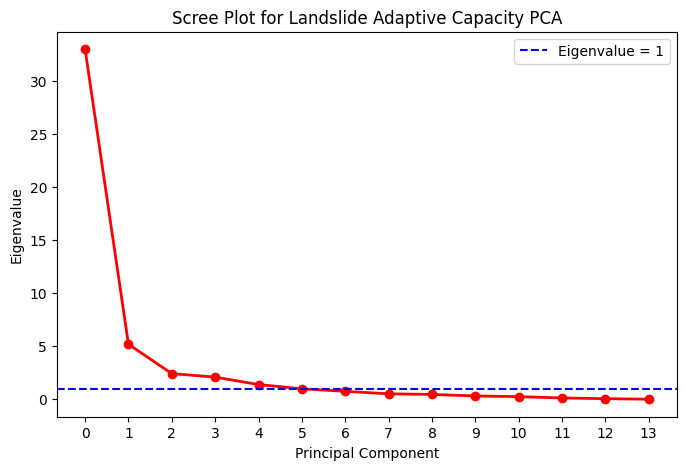

In [6]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
xvals = np.arange(len(eigenvalues))

plt.figure(figsize=(8,5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2)
plt.title("Scree Plot for Landslide Adaptive Capacity PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue = 1")
plt.xticks(xvals)
plt.legend()
plt.show()


In [8]:
loadings_acap = pd.DataFrame(
    pca_n.components_.T,
    index=acap_pca_vars,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
print(loadings_acap)


                                   PC1       PC2       PC3       PC4       PC5
vill_road_coverage_scaled     0.010813 -0.185573 -0.097109 -0.016902  0.376694
vill_rwh_coverage_scaled      0.003856 -0.094936 -0.049170 -0.015740  0.119732
vill_elec_no_ratio_scaled    -0.012208  0.677179 -0.091147  0.032255  0.134017
vill_elec_mt_12_ratio_scaled -0.012208  0.677179 -0.091147  0.032255  0.134017
road_pop_coverage_scaled      0.012367 -0.150916 -0.093354 -0.015641  0.429336
bc_per_10k_pop_scaled         0.454090  0.036935  0.649086  0.575752  0.142631
branch_per_10k_pop_scaled     0.890174  0.005153 -0.327281 -0.290503 -0.081236
shg_per_1000_hh_scaled       -0.004632  0.030690  0.138826 -0.244624  0.238514
loan_per_hh_scaled           -0.002670 -0.001608  0.228001 -0.359160  0.611608
jobcard_issued_ratio_scaled   0.001288  0.066052  0.444202 -0.460831 -0.138062
active_jobcard_ratio_scaled   0.006099  0.057079  0.355123 -0.395669 -0.201761
pmuy_ratio_scaled            -0.010649 -0.002419  0.

In [7]:
n_components = 5 
pca_n = PCA(n_components=n_components)
X_acap_pca = pca_n.fit_transform(X_acap)

# Get the top PCs' variance ratios
pca_weights = pcaSummary_acap['% variance'][:n_components]

# Create PC columns in DataFrame
for i in range(n_components):
    adaptive_df[f"AdaptCap_PC{i+1}"] = X_acap_pca[:, i]

# Weighted sum => "Landslide_AdaptiveCap_Index"
adaptive_df["Landslide_AdaptiveCap_Index"] = 0
for i in range(n_components):
    adaptive_df["Landslide_AdaptiveCap_Index"] += (
        pca_weights.iloc[i] * adaptive_df[f"AdaptCap_PC{i+1}"]
    )

print(adaptive_df[["block_code", "Landslide_AdaptiveCap_Index"]].head())
print(adaptive_df["Landslide_AdaptiveCap_Index"].describe())


   block_code  Landslide_AdaptiveCap_Index
0        6498                    -0.089144
1        6492                    -1.007412
2        4689                     2.583778
3        4690                    -0.708831
4        4692                    -0.414446
count    5.815000e+03
mean     8.797778e-17
std      4.003821e+00
min     -1.608057e+00
25%     -8.024224e-01
50%     -5.022792e-01
75%     -2.427178e-02
max      1.934649e+02
Name: Landslide_AdaptiveCap_Index, dtype: float64
